In [15]:
%matplotlib inline

In [16]:
if True:
    import matplotlib.pylab as plt
    import numpy as np
    import matplotlib as mpl
    from matplotlib.pylab import plot, pcolor, imshow
    from matplotlib import animation

In [17]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

from matplotlib import animation

In [18]:
def myfloat(b):
    try: 
        b = float(b)
    except ValueError:
        b = float(b.split('-')[0])*10**(-float(b.split('-')[1]))
    return b

## Grid setup


In [53]:
dryin = []
for line in open("dryin_interp.dat", 'r'):
    dryin.append(line)
    
ncol = 94
nrow = 63
kbeg = [0]
kend = [0]
for line in range(324, 324+ncol):
    a = dryin[line].strip().split(" ")
    a = [int(x) for x in a if x]
    kbeg.append(a[1])
    kend.append(a[2])
    
kbeg.append(kbeg[-1])
kend.append(kend[-1])

In [56]:
# from grid
coords = []
for line in open("coords_interp", 'r'):
    item = line.rstrip()  # strip off newline and any other trailing whitespace
    coords.append(line)
    
npt, ne = [int(j) for j in coords[0].split()]
x = np.zeros(npt + 1)
y = np.zeros(npt + 1)
z = np.zeros(npt + 1)
for i in range(1, npt + 1):
    x[i], y[i], z[i] = [float(l) for l in coords[i].split()]

global nop
nop = np.zeros([ncol + 1, nrow + 1, 4], dtype=int)
count = 0
for j in range(1, ncol + 1):
    for k in range(kbeg[j], kend[j] + 1):
        nop[j, k, :] = [int(l) for l in coords[count + 1 + npt].split()]
        count += 1
        

In [57]:
xc = np.zeros([ncol + 2, nrow + 2])  # coordinates of cell centers
yc = np.zeros([ncol + 2, nrow + 2])
zc = np.zeros([ncol + 2, nrow + 2])

for j   in range(1, ncol + 1):  # Compute grid metrics
    for k in range(kbeg[j], kend[j] + 1):
        n1 = nop[j, k, 0]
        n2 = nop[j, k, 1]
        n3 = nop[j, k, 2]
        n4 = nop[j, k, 3]
        xc[j, k] = 0.25 * (x[n1] + x[n2] + x[n3] + x[n4])
        yc[j, k] = 0.25 * (y[n1] + y[n2] + y[n3] + y[n4])
        zc[j, k] = 0.25 * (z[n1] + z[n2] + z[n3] + z[n4])

In [58]:
itp = []  #  print step
it = []   #  time step
f =  open("time.out", 'r')
f.next()
for line in f:
        a = (line.strip().split(" "))
        a = [b for b in a if b]
        itp.append(int(a[1]))
        it.append(int(a[2]))

ntstep = len(itp)
print ntstep

109


In [59]:
h = []
hdum =  np.zeros([ncol+2, nrow+2])

for line in open("myout.out", 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]
    try:
        j = int(a[0])
        k = int(a[1])
        hdum[j,k] = a[2] 
    except IndexError:
        dumt = int(a[0])
        h.append(hdum.copy())

h = np.array(h)
if len(h)!= ntstep:
    print "wrong shape"

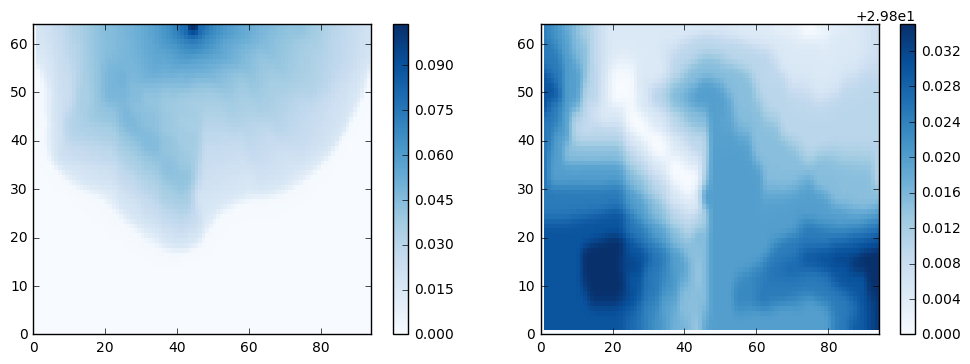

In [60]:
plt.figure(figsize = (12, 4))
tdum = ntstep - 1
plt.subplot(121)
plt.pcolor( h[tdum].T, cmap = 'Blues')
plt.xlim(0, 94); plt.ylim(0, 64)
plt.colorbar()
plt.subplot(122)
plt.pcolor( zc.T, cmap = 'Blues', norm = 
           mpl.colors.Normalize(vmin=29.8,vmax=29.835))
plt.xlim(0, 94); plt.ylim(0, 64)
plt.colorbar()


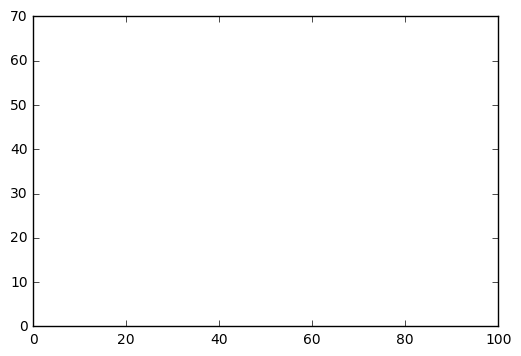

In [61]:
fig2 = plt.figure();
ims = []

for add in np.arange(ntstep):
    ims.append((plt.pcolor( h[add, 1:-1, 1:-1].T, 
                           cmap = 'Blues', norm=plt.Normalize(0, .1)), ))

im_ani = animation.ArtistAnimation(fig2, ims, interval=100, repeat_delay=3000,
                                   blit=False)
im_ani.save('h_test.mp4')

In [62]:
display_animation(im_ani)

In [63]:
f = []
fdum = np.zeros([ncol+1 ]) 

for line in open("fluxes.out", 'r'):
    a = (line.strip().split(" "))
    
    try:
        a = [str(b) for b in a if b]        
        j = int(a[0])
        k = int(a[1])
        fdum[j] = a[2]   
    except IndexError:
        dumt = int(a[0])
        f.append(fdum.copy())
f = np.array(f)
nfstep = len(f)      

In [64]:
 
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 94), ylim=(-.06, .01))
line, = ax.plot([], [], lw=1)
plt.title('flux ($hv$) along top boundary')
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.arange(95)
    y = f[i]
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nfstep,
                               interval= 100, blit=True)

anim.save('flux_test.mp4', metadata={'boundary':'top', 'nsteps': str(ntstep)})
# call our new function to display the animation
display_animation(anim)
